# Logistic regression

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm_notebook as tqdm
import matplotlib as mpl

In [2]:
# Numeric pNML
def add_to_test(x_train, y_train, x, y):
    return np.concatenate((x_train, x)), np.concatenate((y_train, y))


def calc_numerical_regres(
    phi_train: np.ndarray, y_train: np.ndarray, phi_test: np.ndarray
) -> np.ndarray:
    regret_list = []
    for phi in tqdm(phi_test):
        phi = np.expand_dims(phi, 0)

        phi_all, y_all = add_to_test(phi_train, y_train, phi, np.array([0]))
        clf = LogisticRegression(random_state=0, C=np.inf).fit(phi_all, y_all)
        p0 = clf.predict_proba(phi)[0][0]

        phi_all, y_all = add_to_test(phi_train, y_train, phi, np.array([1]))
        clf = LogisticRegression(random_state=0, C=np.inf).fit(phi_all, y_all)
        p1 = clf.predict_proba(phi)[0][1]

        regret = np.log2(p0 + p1)
        regret_list.append(regret)
    return np.asarray(regret_list)

# 2D Data

In [3]:
x_train = np.array([-0.8, -0.75, -0.7, -0.65, -0.6, -0.4, 0.4, 0.45, 0.8, 0.85])
x_train = np.vstack((x_train, np.zeros(x_train.shape[0]))).T
y_train = np.array([0, 0, 0, 0, 0, 0, 1, 1, 1, 0])

x_train = np.array([-0.8, -0.75, -0.7, -0.65, -0.6, -0.4, 0.4, 0.45, 0.8, 0.85])
x_train = np.vstack((x_train, np.zeros(x_train.shape[0]))).T
y_train = np.array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1])

print(f"Trainset:")
print(f"\tlabels: {y_train}")
print(f"\tdata:\n{x_train}")
assert x_train.shape[0] == y_train.shape[0]


# Test
xy_range = np.arange(-1.2, 1.2, 0.05)
x_test = np.array([[x, y] for x in xy_range for y in xy_range]).round(3)
print(f"Test shape {x_test.shape}")

Trainset:
	labels: [0 0 0 0 0 0 1 1 1 1]
	data:
[[-0.8   0.  ]
 [-0.75  0.  ]
 [-0.7   0.  ]
 [-0.65  0.  ]
 [-0.6   0.  ]
 [-0.4   0.  ]
 [ 0.4   0.  ]
 [ 0.45  0.  ]
 [ 0.8   0.  ]
 [ 0.85  0.  ]]
Test shape (2304, 2)


## ERM predicition

[[22.91478929  0.        ]]


<Figure size 432x288 with 0 Axes>

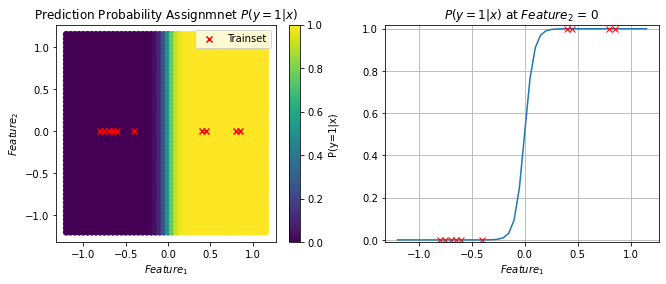

In [4]:
phi_train, phi_test = x_train, x_test
clf = LogisticRegression(random_state=0, C=np.inf).fit(phi_train, y_train)
probs = clf.predict_proba(phi_test)
w_N = clf.coef_.copy()
print(w_N)

w, h = plt.figure().get_size_inches()
fig, axs = plt.subplots(1, 2, figsize=(w * 1.8, h))
ax = axs[0]
im = ax.scatter(phi_test[:, 0], phi_test[:, 1], c=probs[:, 1], cmap="viridis")
ax.scatter(phi_train[:, 0], phi_train[:, 1], marker="x", color="r", label="Trainset")
ax.set_xlabel(r"$Feature_1$")
ax.set_ylabel(r"$Feature_2$")
fig.colorbar(im, label="P(y=1|x)", ax=ax)
ax.legend()
ax.set_title(r"Prediction Probability Assignmnet $P(y=1|x)$")

# 1D plots
indx_on_zero = phi_test[:, 1] == 0.0
ax = axs[1]
ax.plot(phi_test[indx_on_zero, 0], probs[indx_on_zero, 1])
ax.plot(phi_train[:, 0], y_train, "rx", label="Trainset")
ax.set_title(r"$P(y=1|x)$ at $Feature_2$ = 0")
ax.set_ylim(-0.01, 1.02)
ax.set_xlabel(r"$Feature_1$")
ax.grid()
plt.show()

## pNML

In [5]:
# Numerical pNML
regret_numerical = calc_numerical_regres(phi_train, y_train, phi_test)

In [6]:
# Analytical pNML
regret_analytic, projections, responces = [], [], []

corr = np.linalg.pinv(phi_train).dot(phi_train)
for phi in tqdm(phi_test):
    projection_i = phi.dot(np.eye(corr.shape[0]) - corr).dot(phi.T)

    eps = 0 if projection_i > 1e-20 else 10  # 1e-6 20
    #     eps = 1e-21
    z = w_N.dot(phi.T)
    regret_i = np.log2(
        1 + 1 / (1 + 2 * (eps ** projection_i) * np.cosh(z * (1 + projection_i)))
    )
    regret_analytic.append(regret_i)
    projections.append(projection_i)
    responces.append(z)

projections = np.asarray(projections).squeeze()
regret_analytic = np.asarray(regret_analytic).squeeze()
responces = np.asarray(responces).squeeze()

In [7]:
# # Tune eps
# idx_of_max = np.where(np.logical_and(phi_test[:, 0] == 0.0, phi_test[:, 1] == 0.0))[0]
# phi = phi_test[idx_of_max]

# for eps in np.logspace(-30, 1, 30):
#     projection_i = phi.dot(np.eye(corr.shape[0]) - corr).dot(phi.T)
#     z = w_N.dot(phi.T)
#     regret_i = np.log2(
#         1 + 1 / (1 + 2 * (eps ** projection_i) * np.cosh(z * (1 + projection_i)))
#     )
#     print(eps, regret_i)

/Users/kobibi/anaconda3/envs/pt36/lib/python3.6/site-packages/ipykernel_launcher.py:60: UserWarning: Data has no positive values, and therefore cannot be log-scaled.


<Figure size 432x288 with 0 Axes>

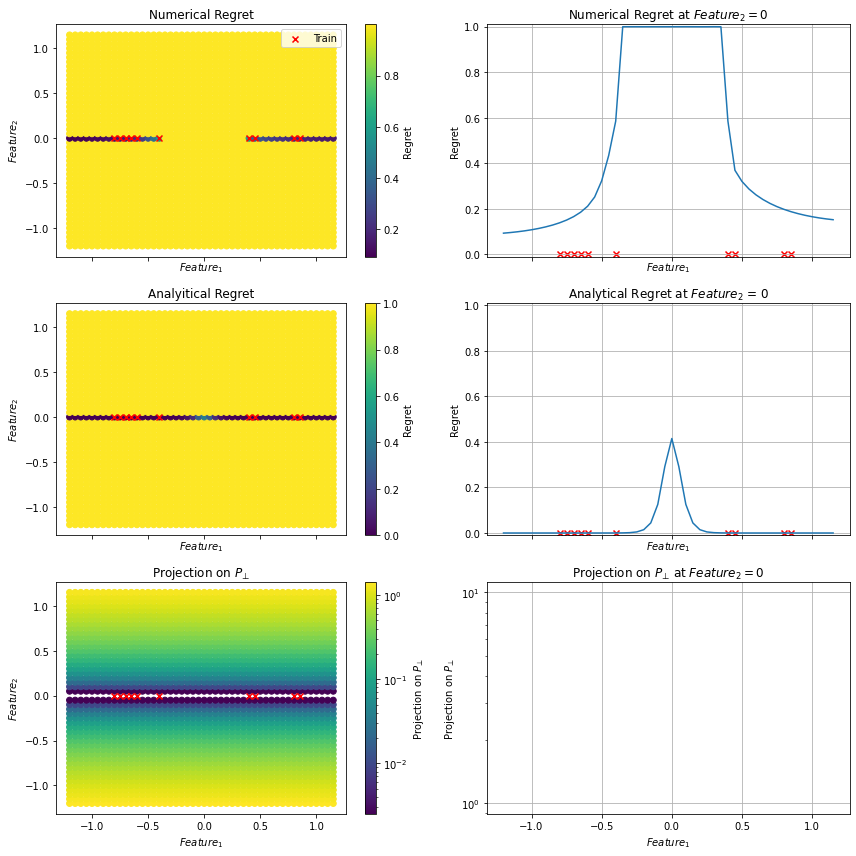

In [8]:
w, h = plt.figure().get_size_inches()
fig, axs = plt.subplots(3, 2, sharex=True, figsize=(w * 2, h * 3))

ax = axs[0, 0]
im = ax.scatter(phi_test[:, 0], phi_test[:, 1], c=regret_numerical, cmap="viridis")
ax.scatter(phi_train[:, 0], phi_train[:, 1], marker="x", color="r", label="Train")
ax.set_xlabel(r"$Feature_1$")
ax.set_ylabel(r"$Feature_2$")
ax.set_title("Numerical Regret")
ax.legend(loc=1)
fig.colorbar(im, label="Regret", ax=ax)

ax = axs[1, 0]
im = ax.scatter(phi_test[:, 0], phi_test[:, 1], c=regret_analytic, cmap="viridis")
ax.scatter(phi_train[:, 0], phi_train[:, 1], marker="x", color="r", label="Train")
ax.set_xlabel(r"$Feature_1$")
ax.set_ylabel(r"$Feature_2$")
ax.set_title("Analyitical Regret")

fig.colorbar(im, label="Regret", ax=ax)

ax = axs[2, 0]
im = ax.scatter(
    phi_test[:, 0],
    phi_test[:, 1],
    c=projections,
    cmap="viridis",
    norm=mpl.colors.LogNorm(),
)
ax.scatter(phi_train[:, 0], phi_train[:, 1], marker="x", color="r", label="Trainset")
ax.set_xlabel(r"$Feature_1$")
ax.set_ylabel(r"$Feature_2$")
fig.colorbar(im, label=r"Projection on $P_\bot$", ax=ax)
ax.set_title(r"Projection on $P_\bot$")


# 1D plots
indx_on_zero = phi_test[:, 1] == 0.0

ax = axs[0, 1]
ax.plot(phi_test[indx_on_zero, 0], regret_numerical[indx_on_zero])
ax.scatter(phi_train[:, 0],[0]*len(phi_train), marker="x", color="r", label="Trainset")
ax.set_ylabel("Regret")
ax.set_xlabel(r"$Feature_1$")
ax.set_title(r"Numerical Regret at $Feature_2=0$")
ax.grid()
ax.set_ylim(-0.01, 1.01)

ax = axs[1, 1]
ax.plot(phi_test[indx_on_zero, 0], regret_analytic[indx_on_zero])
ax.scatter(phi_train[:, 0],[0]*len(phi_train), marker="x", color="r", label="Trainset")
ax.set_ylabel("Regret")
ax.set_xlabel(r"$Feature_1$")
ax.set_title(r"Analytical Regret at $Feature_2$ = 0")
ax.grid()
ax.set_ylim(-0.01, 1.01)

ax = axs[2, 1]
ax.plot(phi_test[indx_on_zero, 0], projections[indx_on_zero])
ax.set_yscale("log")
ax.set_ylabel(r"Projection on $P_\bot$")
ax.set_xlabel(r"$Feature_1$")
ax.set_title(r"Projection on $P_\bot$ at $Feature_2=0$")
ax.grid()

plt.tight_layout()
plt.show()

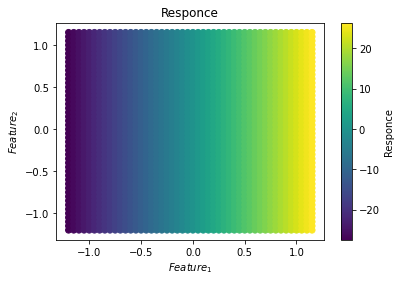

26.35200767914883 -27.49774714345965


In [9]:
fig, ax = plt.subplots(1, 1)
im = ax.scatter(phi_test[:, 0], phi_test[:, 1], c=responces, cmap="viridis")
ax.set_xlabel(r"$Feature_1$")
ax.set_ylabel(r"$Feature_2$")
ax.set_title("Responce")
fig.colorbar(im, label="Responce", ax=ax)
plt.show()
print(responces.max(), responces.min())

In [10]:
projections[indx_on_zero]

array([-3.19744231e-16, -2.93653990e-16, -2.68673972e-16, -2.44804177e-16,
       -2.22044605e-16, -2.00395256e-16, -1.79856130e-16, -1.60427227e-16,
       -1.42108547e-16, -1.24900090e-16, -1.08801856e-16, -9.38138456e-17,
       -7.99360578e-17, -6.71684930e-17, -5.55111512e-17, -4.49640325e-17,
       -3.55271368e-17, -2.72004641e-17, -1.99840144e-17, -1.38777878e-17,
       -8.88178420e-18, -4.99600361e-18, -2.22044605e-18, -5.55111512e-19,
        0.00000000e+00, -5.55111512e-19, -2.22044605e-18, -4.99600361e-18,
       -8.88178420e-18, -1.38777878e-17, -1.99840144e-17, -2.72004641e-17,
       -3.55271368e-17, -4.49640325e-17, -5.55111512e-17, -6.71684930e-17,
       -7.99360578e-17, -9.38138456e-17, -1.08801856e-16, -1.24900090e-16,
       -1.42108547e-16, -1.60427227e-16, -1.79856130e-16, -2.00395256e-16,
       -2.22044605e-16, -2.44804177e-16, -2.68673972e-16, -2.93653990e-16])